# Introduction to Computational Modeling and Simulation for Model-based Design

Outline for Module 2 (Computational Modeling and Simulation): 
1. Computer models and simulation overview
    1. Computational (numerical) model types:
        1. Empirical, data-driven
        2. Mechanistic, first principles
    2. Simulation types:
        1. Stochastic vs. Deterministic
        2. Steady-state vs. Transient
        3. Continuous vs. Discrete
2. Simulation schemes:
    1. Time-stepping
    2. Event-based
    3. Monte Carlo
    4. Agent-based
    5. Finite element

## Computational (numerical) model types

### Empirical, data-driven (_grey-box_ and _black-box_)

- Collect real-world data on physical phenomenon
- Create model that uses collected data to estimate physical phenomenon (system identification):
    - Frequentist regression techniques
    - Bayesian regression techniques
    - Nonlinear system identification
        - NARMAX (nonlinear auto-regressive moving average model)
        - Volterra series
        - Stochastic nonlinear model

### Mechanistic, first principles (_white-box_)

- Use mathematics that models a phenomenon at different levels
- Usually involves either partial differential equations (PDEs) or ordinary differential equations (ODEs)
- Create model that estimates physical phenomenon through computation:
    - Deterministic:
        - Discrete-event problems
        - Finite state machines
        - Initial value problem (ODEs)
        - Boundary value problem (ODEs)
        - Finite element method for boundary value problems (PDEs)
    - Stochastic:
        - Stochastic processes
        - Markov chains

### Simulating an electrical circuit (transient analysis as initial value problem)

Let's say that we have the following circuit:

![RC circuit](rc_circuit.gif)

_Figure 1: RC series circuit_

In this case, V is a DC constant voltage. We know that from our previous knowledge:

$V_R = R \cdot i$ and $V_C = \frac{1}{C} \int i \cdot dt$ and $i = \frac{dq}{dt}$, where:
- $i$ is the electrical current in Amps
- $q$ is the electrical charge in Coulombs
- $t$ is time in seconds

What can we use to solve for $V_C$ generically in terms of $R$, $V$, and $C$, assuming $V_C(0) = 0$?

We know through Kirchoff's that:  $V_C +  V_R = V$ (or alternatively $V - V_R - V_C = 0$).

$\frac{1}{C} \int i dt + i R = V$

Let's do the substitution to make $i$ a bit simpler to calculate:

$\frac{1}{C} q + \frac{dq}{dt} R = V$

Move it around so it's easy to get $\frac{dq}{dt}$:

$\frac{dq}{dt} R = V - \frac{q}{C}$


$\frac{dq}{dt} = \frac{V - \frac{q}{C}}{R}$

How would we get this in terms of $V_C$?

$V_C = \frac{q}{C}$, then $\frac{dq}{dt} = \frac{V - V_c}{R}$

$\frac{dV_c}{dt} = \frac{d}{dt}( \frac{q}{C})$ then we can just use $\frac{dq}{dt} = \frac{C dV_c}{dt}$

Combine and substitute terms:

$\frac{C dV_c}{dt} = \frac{V - V_c}{R}$

$\frac{dV_c}{dt} = \frac{V - V_c}{R C}$

Now, let's use `scipy.integrate` to solve this ODE for $V_C$ numerically, assuming $R = 5 \Omega$, $C = 0.02 F$, $V = 100 V$, and the initial value of $V_C(0) = 0$, $dV_C(0) = 0$:

In [28]:
import numpy as np
import scipy.integrate


def dvc_dt(t: float, vc: np.ndarray) -> np.ndarray:
    v_battery = 100.  # V
    c_capacitor = 0.02  # F
    r_resistor = 5  # ohms
    return (v_battery - vc) / (r_resistor * c_capacitor)


vc_sol = scipy.integrate.solve_ivp(dvc_dt, (0., 2.0), [0.0],
                                   t_eval=np.linspace(0., 2.0, 1000))
# vc_sol

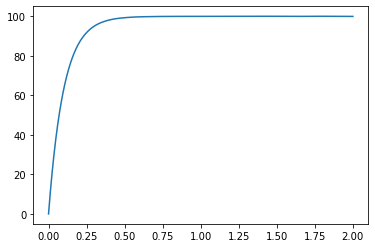

In [29]:
import matplotlib.pyplot as plt

plt.plot(vc_sol.t, vc_sol.y[0, :])

When we run the simulation (numerical integration) for different parameter values (such as different $R$s, $C$s, and $V$s), this is called a **parameter sweep**.  Parameter sweeps make up the bulk of design engineering in combination with optimization.  Let's run a parameter sweep and visualize the time it takes to reach $V$ with different $R$ and $C$ values:

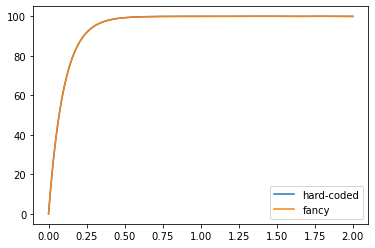

In [30]:
def dvc_dt_fancy(t: float, vc: np.ndarray, v_battery: float,
                 c_capacitor: float, r_resistor: float) -> np.ndarray:
    return (v_battery - vc) / (r_resistor * c_capacitor)


vcf_sol = scipy.integrate.solve_ivp(dvc_dt_fancy, (0., 2.0), [0.0],
                                    t_eval=np.linspace(0., 2.0, 1000),
                                    args=(100., 0.02, 5.0))
plt.plot(vc_sol.t, vc_sol.y[0, :], label='hard-coded')
plt.plot(vcf_sol.t, vcf_sol.y[0, :], label='fancy')
plt.legend()

Now, let's say that V is no longer a single DC voltage, but instead is an AC source: $V = 85 \cos 150t$.

Let's see how we can modify the ODE and solve this numerically:

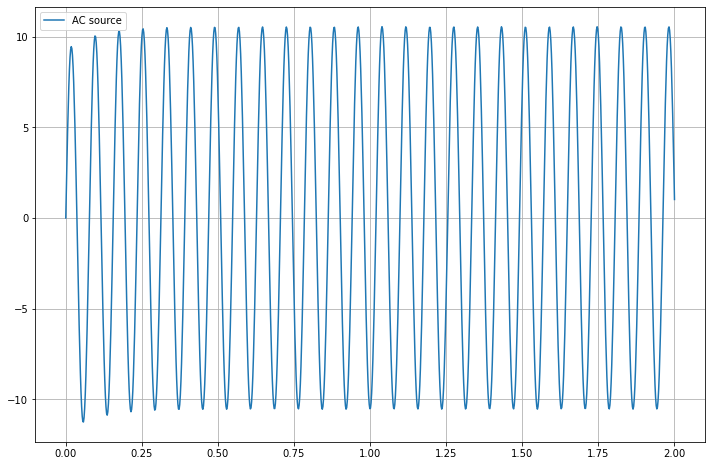

In [74]:
def dvc_dt_ac(t: float, vc: np.ndarray, v_amplitude: float,
              c_capacitor: float, r_resistor: float) -> np.ndarray:
    v_source = v_amplitude * np.cos(80 * t)
    return (v_source - vc) / (r_resistor * c_capacitor)


vc_ac_sol = scipy.integrate.solve_ivp(dvc_dt_ac, (0., 2.0), [0.0],
                                      t_eval=np.linspace(0., 2.0, 1000),
                                      args=(85., 0.02, 5.0))
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(vc_ac_sol.t, vc_ac_sol.y[0, :], label='AC source')
plt.legend()

We see indeed that the capacitor has modified the phase of

### Solving a system of ODEs

Also known as Lotka-Volterra equations, the predator-prey equations are a pair of first-order non-linear ordinary differential equations. They represent a simplified model of the change in populations of two species which interact via predation. For example, foxes (predators) and rabbits (prey). Let $x$ and $y$ represent rabbit and fox populations, respectively:

$\frac{dx}{dt} = x(a - by)$ and $\frac{dy}{dt} = -y(c -dx)$

Let's see how we can solve this using `scipy.integrate`, assuming a positive values for $a$, $b$, $c$, and $d$:

In [57]:
def d_lotka_volterra(t: float, system_values: np.ndarray, 
                     a: float, b: float, c: float, d: float) -> np.ndarray:
    """
    d_lotka_volterra(t, system_values) will compute the LV ODE given time t and
      system values in system_values, where system_values[0] is x and system_values[1] is y.
    """
    # print(system_values.shape)
    dx_dt = system_values[0] * (a - b * system_values[1])
    dy_dt = -system_values[1] * (c - d * system_values[0])
    return np.array((dx_dt, dy_dt))

In [58]:
lv_sol = scipy.integrate.solve_ivp(d_lotka_volterra, (0., 15.0), (10, 5),
                                   t_eval=np.linspace(0., 15.0, 100),
                                   args=(1.5, 1, 3, 1))

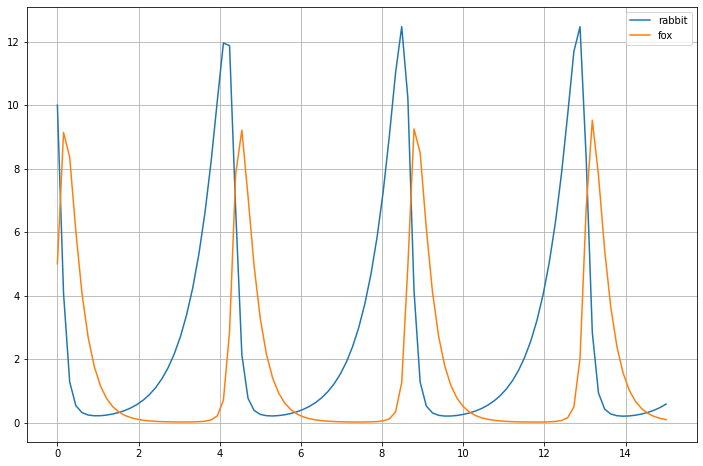

In [59]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(lv_sol.t, lv_sol.y[0, :], label='rabbit')
plt.plot(lv_sol.t, lv_sol.y[1, :], label='fox')
plt.legend()

Let's try it vectorized:

In [67]:
def d_lotka_volterra_vt(t: np.ndarray, system_values: np.ndarray, 
                        a: float, b: float, c: float, d: float) -> np.ndarray:
    """
    d_lotka_volterra_vt(t, system_values) will compute the LV ODE given time t and
      system values in system_values, where system_values[0] is x and system_values[1] is y.
    """
    # print(system_values.shape)
    dx_dt = system_values[0, :] * (a - b * system_values[1, :])
    dy_dt = -system_values[1, :] * (c - d * system_values[0, :])
    return np.array((dx_dt, dy_dt))

In [68]:
lv_vt_sol = scipy.integrate.solve_ivp(d_lotka_volterra_vt, (0., 15.0), (10, 5),
                                      t_eval=np.linspace(0., 15.0, 100),
                                      vectorized=True,
                                      method="Radau",
                                      args=(1.5, 1, 3, 1))

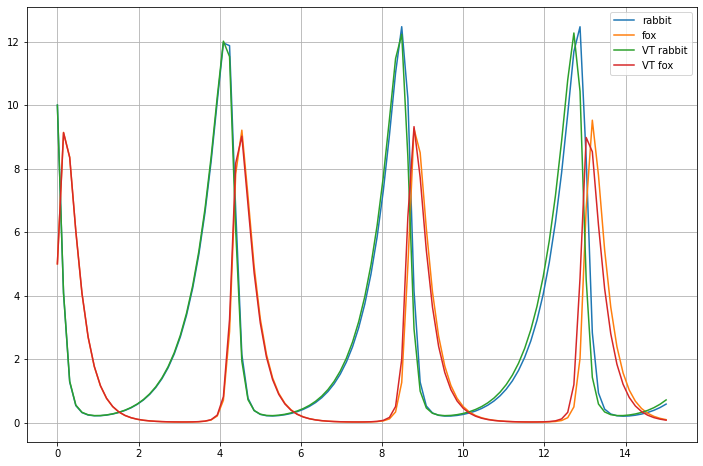

In [69]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(lv_sol.t, lv_sol.y[0, :], label='rabbit')
plt.plot(lv_sol.t, lv_sol.y[1, :], label='fox')
plt.plot(lv_vt_sol.t, lv_vt_sol.y[0, :], label='VT rabbit')
plt.plot(lv_vt_sol.t, lv_vt_sol.y[1, :], label='VT fox')
plt.legend()

### What about a boundary value problem?

We often use BVPs to solve control systems problems: http://acme.byu.edu/wp-content/uploads/2021/01/ObstacleAvoidance.pdf

Let's do Problem 1 as a warm-up:

Problem 2 defines object avoidance as an optimal control problem, represented as a BVP.